
# Neural Network-Based Object Detection

This notebook demonstrates the use of pre-trained TensorFlow models in conjunction with OpenCV to perform object detection on a dataset of images.
We will use two different models:
1. A face detection model
2. A general object detection model (used for identifying people)

---

## Objectives

- Load and use pre-trained neural network models.
- Use OpenCV's DNN module to perform object detection.
- Sort scene images into folders based on detection results.
- Analyze detection accuracy using provided manifest files.

---


In [1]:

import cv2
import os
import pandas as pd
import json
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Face Detection Using a Pretrained TensorFlow Model

We begin by loading a neural network model designed for detecting human faces. This model requires a `.pb` and `.pbtxt` file which define the weights and configuration of the neural network.

We'll use OpenCV's `dnn.readNetFromTensorflow()` and process each image using `cv2.dnn.blobFromImage()` to prepare it for inference.


In [2]:

# Define model files (update these if needed)
model_path = "resources-nn_models/opencv_face_detector_uint8.pb"
config_path = "resources-nn_models/opencv_face_detector.pbtxt"

# Load the pretrained model
net = cv2.dnn.readNetFromTensorflow(model_path, config_path)

# Define input directory
input_dir = "resources-nn_dataset_1"
output_dir = Path("output/faces")
(output_dir / "positive").mkdir(parents=True, exist_ok=True)
(output_dir / "negative").mkdir(parents=True, exist_ok=True)

# Detection threshold
threshold = 0.5

# Process images
image_files = [f for f in Path(input_dir).iterdir() if f.suffix in [".jpg", ".png"]]
print(f"Found {len(image_files)} images.")

for img_path in image_files:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104, 117, 123), False, False)
    net.setInput(blob)
    detections = net.forward()

    detected = False
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            detected = True

    save_path = output_dir / ("positive" if detected else "negative") / img_path.name
    cv2.imwrite(str(save_path), img)


Found 30 images.



## Person Detection Using SSD and Class JSON File

Now we use a general object detection model (SSD + Inception) that can detect multiple objects and classify them. We use a `classes.json` file to map the class index to a label.


In [3]:
# Load model
net = cv2.dnn.readNetFromTensorflow(
    "resources-nn_models/frozen_inference_graph.pb",
    "resources-nn_models/ssd_inception_v2_coco_2017_11_17.pbtxt"
)



# Load class labels
with open("resources-nn_models/classes.json") as f:
    class_names = json.load(f)

# Target class
target_class = "person"
target_index = class_names.index(target_class)

# Output folder
output_dir = Path("output/persons")
(output_dir / "positive").mkdir(parents=True, exist_ok=True)
(output_dir / "negative").mkdir(parents=True, exist_ok=True)

# Detection threshold
threshold = 0.5

# Reuse images from dataset
for img_path in image_files:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward()

    detected = False
    for detection in detections[0, 0]:
        confidence = float(detection[2])
        class_id = int(detection[1])

        if confidence > threshold and class_id == target_index:
            box = detection[3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, target_class, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            detected = True

    save_path = output_dir / ("positive" if detected else "negative") / img_path.name
    cv2.imwrite(str(save_path), img)


In [4]:
def evaluate_detection_results(manifest_file, output_positive_dir, output_negative_dir, title="Confusion Matrix", save_path=None):
    # Read the ground truth
    with open(manifest_file, 'r') as f:
        true_positives = set(line.strip() for line in f if line.strip())

    # Get filenames from output folders
    detected_positives = set(os.listdir(output_positive_dir))
    detected_negatives = set(os.listdir(output_negative_dir))

    # Create true and predicted labels
    y_true = []
    y_pred = []
    all_filenames = detected_positives.union(detected_negatives)

    for filename in all_filenames:
        actual = 1 if filename in true_positives else 0
        predicted = 1 if filename in detected_positives else 0
        y_true.append(actual)
        y_pred.append(predicted)

    # Force labels to [0, 1] even if one is missing
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.grid(False)

    # Save plot if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    # Print breakdown
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives:  {tp}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Negatives:  {tn}")
    return cm


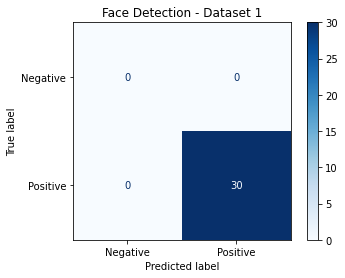

True Positives:  30
False Positives: 0
False Negatives: 0
True Negatives:  0


array([[ 0,  0],
       [ 0, 30]], dtype=int64)

In [5]:
evaluate_detection_results(
    manifest_file="resources-nn_dataset_1/nn_dataset_1_face_manifest.txt",
    output_positive_dir="./output/faces/positive",
    output_negative_dir="./output/faces/negative",
    title="Face Detection - Dataset 1",
    save_path=r"./output/face_confusion_matrix.png"
)

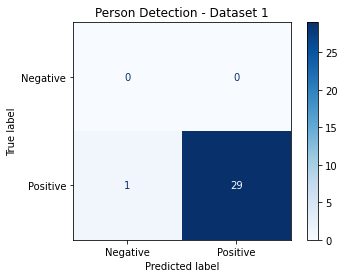

True Positives:  29
False Positives: 0
False Negatives: 1
True Negatives:  0


array([[ 0,  0],
       [ 1, 29]], dtype=int64)

In [6]:
evaluate_detection_results(
    manifest_file="resources-nn_dataset_1/nn_dataset_1_person_manifest.txt",
    output_positive_dir="./output/persons/positive",
    output_negative_dir="./output/persons/negative",
    title="Person Detection - Dataset 1",
    save_path=r"./output/person_confusion_matrix.png"
)